# Romanian painting retrieval

# 1) Test romanian database

-> extract 200 pictures and memorize their output

In [1]:
import cv2
import matplotlib.pyplot as plt
import glob
import os
import shutil
import numpy as np
import torch.nn as nn
import torch
import torchvision.transforms as transforms
import pandas as pd


from torch import Generator
from torch.utils.data import Dataset, DataLoader, Subset, random_split, SubsetRandomSampler
from sklearn.model_selection import train_test_split

e:\Programe\Anaconda\envs\Pytorch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [28]:
mobile_net = torch.hub.load('pytorch/vision:v0.10.0', 'mobilenet_v2', pretrained=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
mobile_net.to(device)

for param in mobile_net.parameters():
    param.requires_grad = False

mobile_net.classifier[1] = nn.Linear(in_features=1280, out_features=18, bias=True)

# LOAD NET
mobile_net.load_state_dict(torch.load('mobileNet_PandoraTrain4.pt'))
mobile_net.cuda()
mobile_net.eval()

Using cache found in C:\Users\Teodora/.cache\torch\hub\pytorch_vision_v0.10.0
e:\Programe\Anaconda\envs\Pytorch\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
e:\Programe\Anaconda\envs\Pytorch\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [29]:
base_path = "E:\Lucru\ANUL II MASTER\MLAV\ProiectDificil\Pandora_18k_Merged\\"

folders = [ f.path for f in os.scandir(base_path) if f.is_dir() ]
classes_names = [ f.name for f in os.scandir(base_path) if f.is_dir() ]
classes = ["1","2","3","4","5","6","7","8","9","10","11","12","13","14","15","16","17","18"]

class_mapping = {
    "01_Byzantin_Iconography": 0,
    "02_Early_Renaissance":1,
    "03_Northern_Renaissance":2,
    "04_High_Renaissance":3,
    "05_Baroque":4,
    "06_Rococo":5,
    "07_Romanticism":6,
    "08_Realism":7,
    "09_Impressionism":8,
    "10_Post_Impressionism":9,
    "11_Expressionism":10,
    "12_Symbolism":11,
    "13_Fauvism":12,
    "14_Cubism":13,
    "15_Surrealism":14,
    "16_AbstractArt":15,
    "17_NaiveArt":16,
    "18_PopArt" : 17
}

inv_class_mapping = {v: k for k, v in class_mapping.items()}


image_path_by_class = []
aux_str = []

for folder in folders:
    aux_str = folder + "//" + "*.jpg"
    image_path_by_class.append(glob.glob(aux_str))
print(classes_names)

['01_Byzantin_Iconography', '02_Early_Renaissance', '03_Northern_Renaissance', '04_High_Renaissance', '05_Baroque', '06_Rococo', '07_Romanticism', '08_Realism', '09_Impressionism', '10_Post_Impressionism', '11_Expressionism', '12_Symbolism', '13_Fauvism', '14_Cubism', '15_Surrealism', '16_AbstractArt', '17_NaiveArt', '18_PopArt']


In [30]:
labels = []
for index, class_path in enumerate(image_path_by_class):
  tmp = []
  for img_path in class_path:
    label = img_path.split("\\")[6]
    tmp.append(label)
  labels.append(tmp)

# len(labels)
targets = []
for label in labels:
    tmp = []
    for img_label in label:
      tmp.append(img_label)
    targets.append(tmp)


In [31]:
base_path_rom = "E:\Lucru\ANUL II MASTER\MLAV\ProiectDificil\Romanian_paintings\Images\\"

# base_path_rom = "E:\Lucru\ANUL II MASTER\MLAV\ProiectDificil\Romanian_paintings\Net"

folders_rom = [ f.path for f in os.scandir(base_path_rom) if f.is_dir() ]

# print(folders_rom)

In [32]:
import pandas as pd

excel_name = "E:\Lucru\ANUL II MASTER\MLAV\ProiectDificil\Romanian_paintings\\romanian_wikiart_2.xlsx"

df = pd.read_excel(excel_name, sheet_name="Lista-completa")

print(df[['image_id']].loc[0]['image_id'])
print(df[['style']].loc[0]['style'])

adam-baltatu_after-rain
Impressionism


Adrian-Ghenie
E:\Lucru\ANUL II MASTER\MLAV\ProiectDificil\Romanian_paintings\Images\\Adrian-Ghenie\adrian-ghenie_the-sunflowers-in-1937.jpg
Label:  Neo-Expressionism


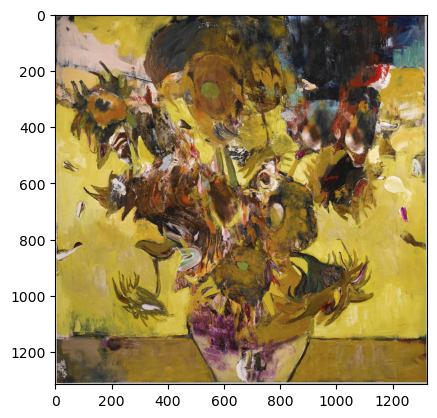

In [33]:
picture_index = 10
artist_index = 100

artist = df[['artist_slug']].loc[artist_index]['artist_slug']
artist = artist.title()
print(artist)

test_picture = base_path_rom + "\\" + artist + "\\" + df[['image_id']].loc[artist_index + picture_index]['image_id'] + ".jpg"
print(test_picture)

img = cv2.imread(test_picture)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure()
plt.imshow(img)
print("Label: ", df[['style']].loc[artist_index + picture_index]['style'])

Real label: Impressionism
tensor([[-86.7954, -45.2571, -59.5117, -41.3234, -97.6840, -29.6824, -65.8147,
           1.6150,  31.4786,  99.3898, -31.0205,  -5.1691, -28.1556, -79.3481,
         -92.3917, -69.6703, -37.4029, -21.6122]], grad_fn=<MulBackward0>)
Predicted label:  10_Post_Impressionism


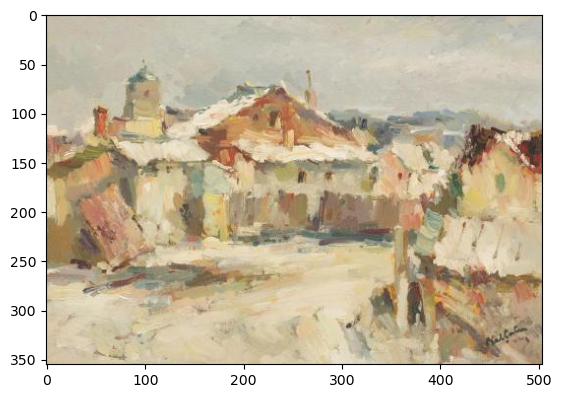

In [83]:
transf = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize([224,224]),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

picture = 10

# test_img = cv2.imread(train_data[picture])
# test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)

picture_index = 50
artist_index = 10
artist = df[['artist_slug']].loc[artist_index]['artist_slug']
artist = artist.title()
test_picture = base_path_rom + "\\" + artist + "\\" + df[['image_id']].loc[artist_index + picture_index]['image_id'] + ".jpg"

img = cv2.imread(test_picture)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.figure()
plt.imshow(img)
print("Real label:", df[['style']].loc[artist_index + picture_index]['style'])

data = transf(img)
data = data.to(torch.device('cuda'))
data = data[None, :]
# data.size()
# test_label = test_labels[picture].to(torch.device('cuda'))


predict = mobile_net.forward(data)
predict = predict.to(torch.device('cpu'))

print(predict * 10)

predict = np.argmax(predict.detach().numpy(),axis=1)
print("Predicted label: ",inv_class_mapping[predict[0]])


In [ ]:
activation2 = {}
def get_activation(name):
    def hook(model, input, output):
        activation2[name] = output.detach()
    return hook

mobile_net.features[18].register_forward_hook(get_activation('Conv2dNormActivation'))
# mobile_net.classifier[1].register_forward_hook(get_activation('Conv2dNormActivation'))
predict = mobile_net(data)
activation2['Conv2dNormActivation']


# Extract the desired romanian pictures

Because we have 80 authors we will extract 5 pictures (=> 400 in total) from each author and calculate the features

In [84]:
## DO NOT RUN

path_rom = "E:\Lucru\ANUL II MASTER\MLAV\ProiectDificil\Romanian_Paintings_400"


excel_name = "E:\Lucru\ANUL II MASTER\MLAV\ProiectDificil\Romanian_paintings\\romanian_only_features_labels.xlsx"
new_excel_name = "E:\Lucru\ANUL II MASTER\MLAV\ProiectDificil\Romanian_paintings\\romanian_with_features.xlsx"

data_frame = pd.read_excel(excel_name)
features=[]
# df = df.assign(features=[])

transf = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize([224,224]),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

activation2 = {}
def get_activation(name):
    def hook(model, input, output):
        activation2[name] = output.detach()
    return hook

activations = []


for index, image in enumerate(data_frame['image_id']):
        picture_path = path_rom + "\\" + image + ".jpg"

        img = cv2.imread(picture_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        data = transf(img)
        data = data.to(torch.device('cuda'))
        data = data[None, :]

        predict = mobile_net.forward(data)
        predict = predict.to(torch.device('cpu'))

        # mobile_net.features[18].register_forward_hook(get_activation('Conv2dNormActivation'))

        # predict = np.argmax(predict.detach().numpy(),axis=1)
        features.append(predict.detach().numpy() * 10)
        # tmp = activation2['Conv2dNormActivation'].to(torch.device('cpu')).detach().numpy()
        # activations.append(tmp)

print(len(features))
print(len(activations))
# print(activations)

data_frame.insert(2,column='features', value=features)
data_frame.to_excel(new_excel_name, index=False)

401
0


In [66]:
print(len(activations[0][0]))


1280


In [ ]:
excel_name = "E:\Lucru\ANUL II MASTER\MLAV\ProiectDificil\Romanian_paintings\\romanian_with_features.xlsx"

data_frame = pd.read_excel(excel_name)

test = data_frame['activations'].loc[0]
print(len(test))
print(type(test))

# test_ft = data_frame['features'].loc[0].split("[[")[1]
# test_ft = test_ft.split("]]")[0]

# print(test_ft)
# print(type(test_ft))

# test = np.fromstring(test_ft, dtype=float, count=- 1, sep = ' ')

# print(test)
# print(type(test))

In [76]:
from scipy.spatial import distance

def dist_euclidian(v1, v2):
    return distance.euclidean(v1, v2)

def dist_cosine(v1, v2):
    return distance.cosine(v1, v2)

def euclidian_dist(vector1, vector2):
    return np.linalg.norm(vector1 - vector2)

# Painting Retrieval

- load a picture
- calculate distance between all features
- choose best 5

Label:  16_AbstractArt
Predicted label:  16_AbstractArt
##################
193.68221148216594
193.68221148216597
##################
[327, 337, 58, 335, 47]
44.23649134288149
69.25439525830448
71.43043758529491
72.213569907844
77.04249299545427


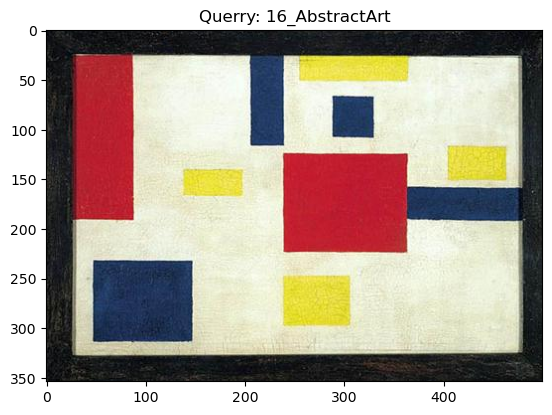

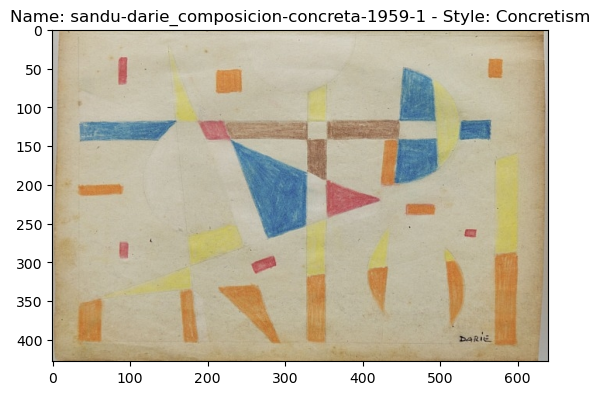

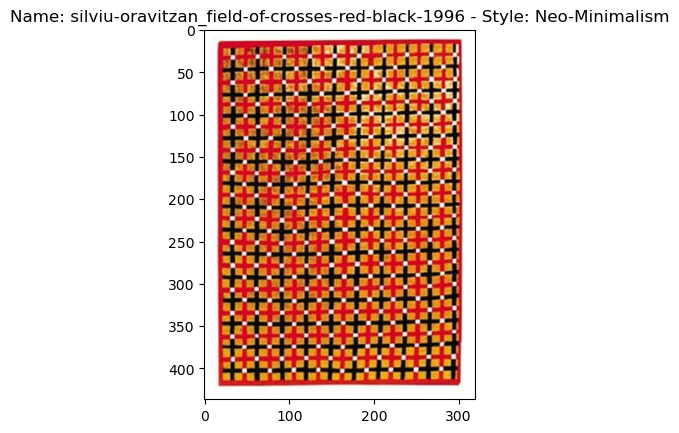

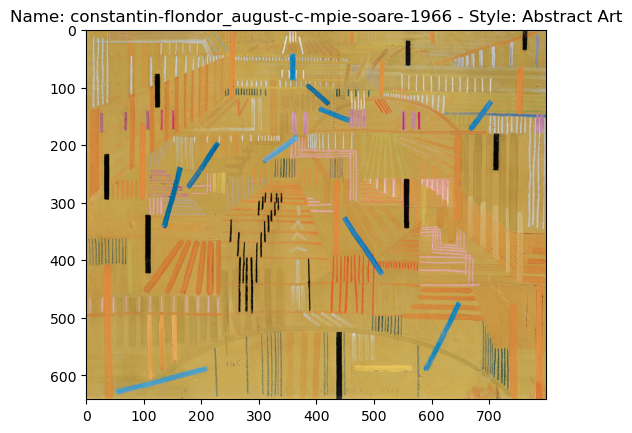

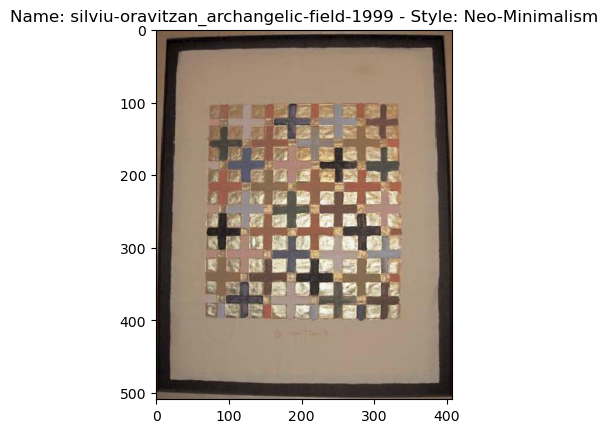

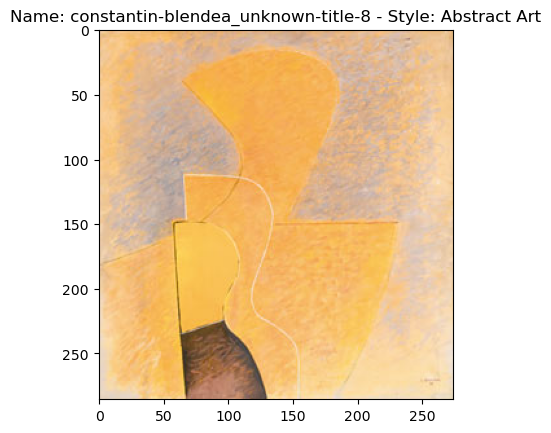

In [95]:
new_excel_name = "E:\Lucru\ANUL II MASTER\MLAV\ProiectDificil\Romanian_paintings\\romanian_with_features.xlsx"
base_path_rom = "E:\Lucru\ANUL II MASTER\MLAV\ProiectDificil\Romanian_paintings\Images\\"

data_frame = pd.read_excel(new_excel_name)
# df = df.assign(features=[])

querry_features = []
features = []

transf = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize([224,224]),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

# load features and transform them into np array
for feature in data_frame['features']:
        feature_tmp = feature.split("[[")[1]
        feature_tmp = feature_tmp.split("]]")[0]

        feature_np = np.fromstring(feature_tmp, dtype=float, count=- 1, sep = ' ')
        features.append(feature_np)


#### LOAD A PICTURE ####
# hardcode_picture_path = "E:\Lucru\ANUL II MASTER\MLAV\ProiectDificil\Pandora_18k_Merged\\06_Rococo\Rococo (33).jpg"
# hardcode_label = "06_Rococo"
# hardcode_trigger = 5

hardcode_picture_path = "E:\Lucru\ANUL II MASTER\MLAV\ProiectDificil\Pandora_18k_Merged\\16_AbstractArt\\AbstractArt (111).jpg"
hardcode_label = "16_AbstractArt"
hardcode_trigger = 1


img = cv2.imread(hardcode_picture_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure()
plt.imshow(img)
plt.title("Querry: {}".format(hardcode_label))
# print("Label: ", df[['style']].loc[artist_index + picture_index]['style'])
print("Label: ", hardcode_label)

data = transf(img)
data = data.to(torch.device('cuda'))
data = data[None, :]

# CALCULATE ITS FEATURES
relu = nn.ReLU()

predict = mobile_net.forward(data)

predict = predict.to(torch.device('cpu'))
predict = predict.detach().numpy()
label_pred = np.argmax(predict)

predict *= 10
# predict = np.argmax(predict.detach().numpy(),axis=1)
print("Predicted label: ",inv_class_mapping[label_pred])

print("######" * 3)

print(dist_euclidian(predict, features[12]))
print(euclidian_dist(predict, features[12]))


print("######" * 3)


### BEGIN THE RETRIEVAL

distances = np.array(0)
distances = []
for index, feature in enumerate(features):
        tmp = dist_euclidian(predict, feature)
        distances.append(tmp)
        # distances = np.append(distances, tmp)

# print(distances)
# # print(distances)
# max_dist = np.argmax(distances)

# max_dist2 = distances.argsort()[:5][::-1]
# print("Best dist: {}".format(max_dist2))

min_dist = []
min_dist = sorted(range(len(distances)), key=lambda i: distances[i], reverse=False)[:5]
print(min_dist)

# PRINT THE BEST APROXIMATES
new_excel_name = "E:\Lucru\ANUL II MASTER\MLAV\ProiectDificil\Romanian_paintings\\romanian_with_features.xlsx"
data_frame2 = pd.read_excel(new_excel_name)

path_rom = "E:\Lucru\ANUL II MASTER\MLAV\ProiectDificil\Romanian_Paintings_400"

for dist in min_dist:
        print(distances[dist])
        picture_path = path_rom + "\\" + data_frame2['image_id'].loc[dist] + ".jpg"
        img = cv2.imread(picture_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        title = "Name: " + data_frame2['image_id'].loc[dist] + " - Style: " + data_frame2['style'].loc[dist] 
        plt.figure()
        plt.imshow(img)
        plt.title(title)




In [74]:
print(distances)

min = 999
i_min = 0
for i in range(len(distances)):
    if distances[i] < min:
        min = distances[i]
        i_min = i

print("Min: {}, i_min: {}".format(min, i_min))


[23.93277983257305, 20.6215753121758, 27.993038741187124, 23.573658092226047, 21.83443606873254, 16.0889048194359, 22.874488528547097, 19.321471597807932, 18.452773537917313, 17.76126783432907, 22.59905792090197, 23.689313681422124, 22.77132996873402, 21.70224153217967, 25.05000905679787, 30.70120738750405, 22.450073576911468, 21.632954204016354, 19.426556110284153, 27.773192189017255, 22.354595372587784, 24.65172694504613, 35.57296095284301, 22.279805579140255, 25.687417405308377, 24.383517956113895, 23.693454988665017, 19.870028393676492, 23.735675320796204, 21.180030994781163, 28.66123624230255, 28.21036837671976, 18.03082565530007, 23.81684655037461, 17.67772794445019, 17.626400630162628, 16.254684308346363, 25.65290746936183, 34.582845736553196, 24.181672327019847, 22.533261368577794, 19.800430226204547, 26.714804513274338, 20.52051953000377, 22.057957901313788, 26.10681676863822, 23.141566992017676, 25.36723589081173, 29.471115843692502, 20.176641046262166, 15.832031779635903, 16